In [1]:
from tensorflow.keras.models import load_model
model = load_model('cats_and_dogs_small_2.h5')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 15, 15, 128)      

In [12]:
img_path = '/root/cats_and_dogs_small/test/cats/cat.1700.jpg'

from tensorflow.keras.preprocessing import image
import numpy as np

img = image.load_img(img_path, target_size=(150, 150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.

img_tensor.shape

(1, 150, 150, 3)

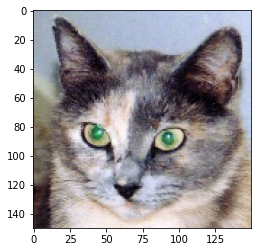

In [13]:
import matplotlib.pyplot as plt

plt.imshow(img_tensor[0])

In [5]:
from tensorflow.keras import models

layer_outputs = [layer.output for layer in model.layers[:8]]
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

In [6]:
activations = activation_model.predict(img_tensor)

In [29]:
for layer in activations:
    print(layer.shape)

(1, 148, 148, 32)
(1, 74, 74, 32)
(1, 72, 72, 64)
(1, 36, 36, 64)
(1, 34, 34, 128)
(1, 17, 17, 128)
(1, 15, 15, 128)
(1, 7, 7, 128)


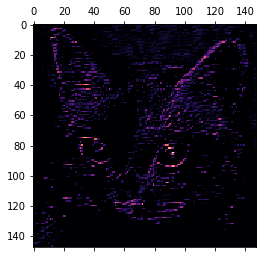

In [40]:
first_layer_activation = activations[0]

plt.matshow(activations[0][0, :, :, 2], cmap='magma')

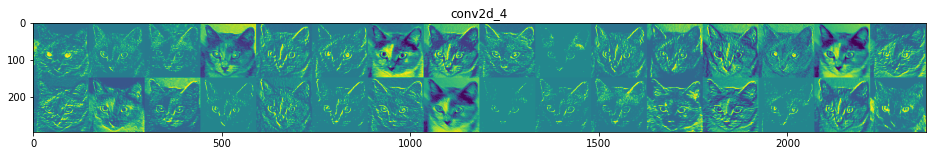

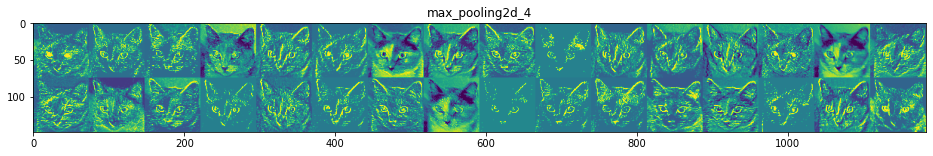

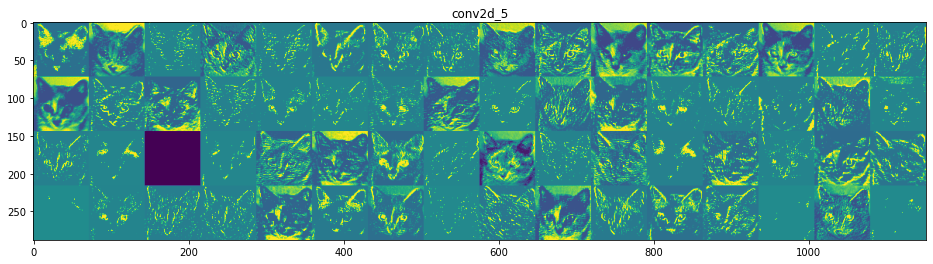

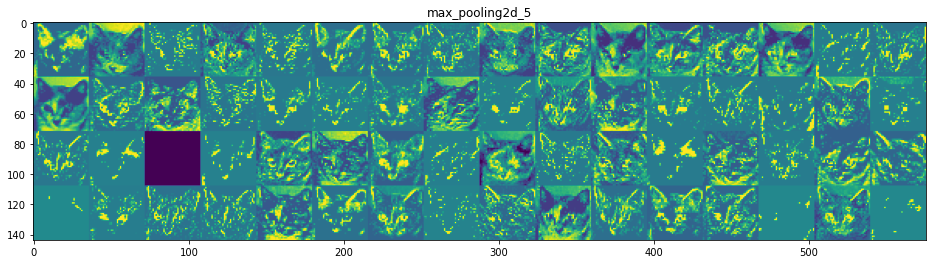

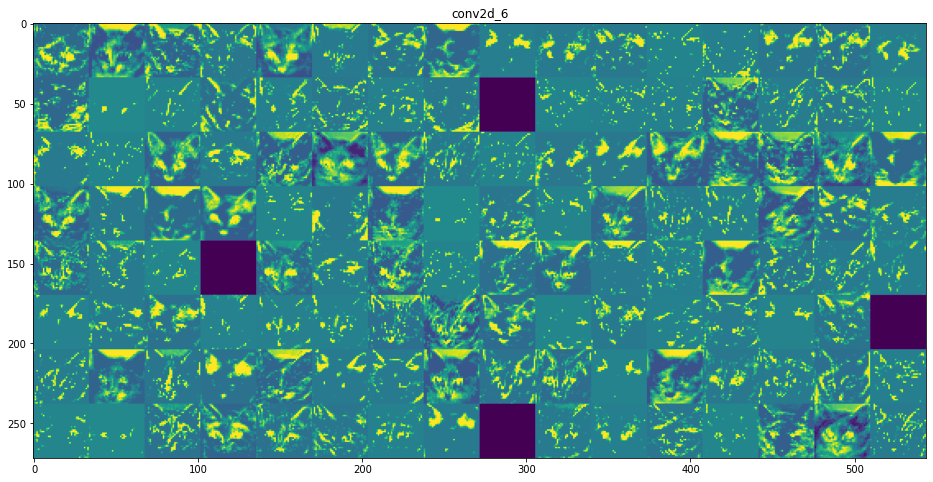

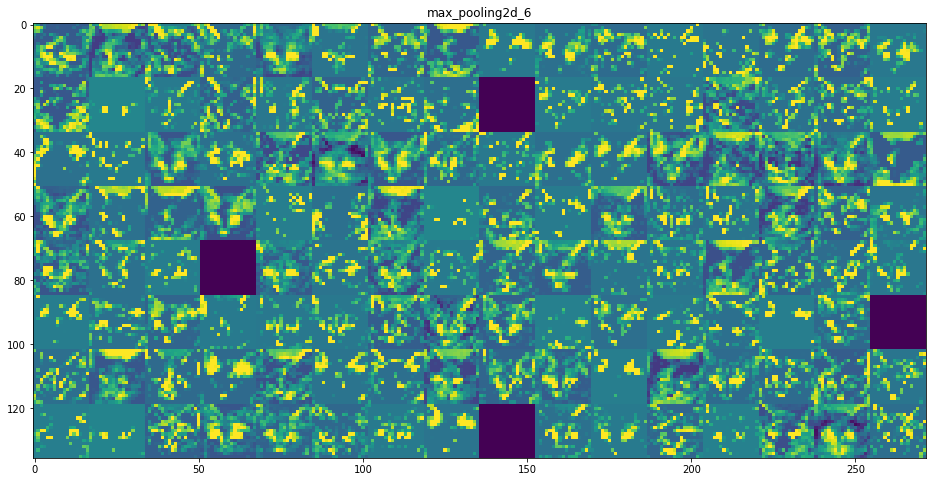

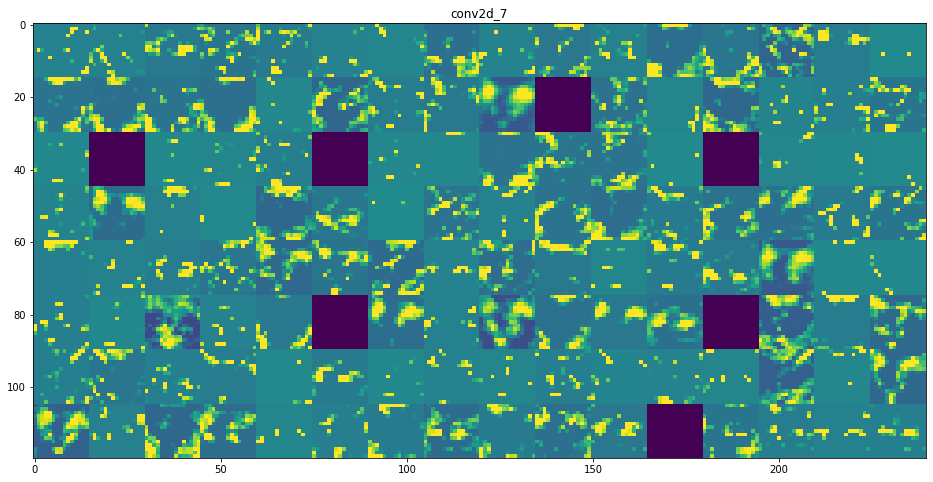

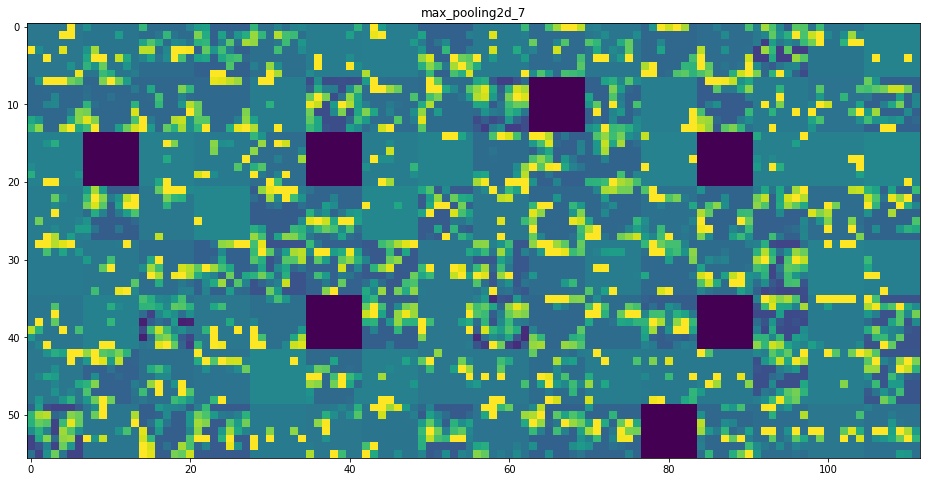

In [44]:
import numpy as np

layer_names = []
for layer in model.layers[:8]:
    layer_names.append(layer.name)
    
images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[-1]
    
    size = layer_activation.shape[1]
    
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,:,:,col * images_per_row + row]
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col+1) * size, row * size : (row+1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

In [18]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import backend as K
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

model = VGG16(weights='imagenet', include_top=False)

layer_name = 'block3_conv1'
filter_index = 0


def deprocess_image(x):
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1
    
    x += 0.5
    x = np.clip(x, 0, 1)
    
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x


def generate_pattern(layer_name, filter_index, size=150):
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:, :, :, filter_index])

    grads = K.gradients(loss, model.input)[0]
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

    iterate = K.function([model.input], [loss, grads])

    import numpy as np

    loss_value, grad_value = iterate([np.zeros((1, 150, 150, 3))])

    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128

    step = 1.
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
        
    img = input_img_data[0]
    return deprocess_image(img)

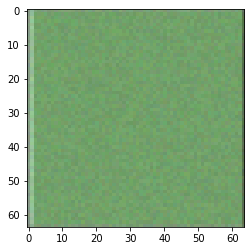

In [30]:
plt.imshow(generate_pattern('block1_conv1', 2, 64))

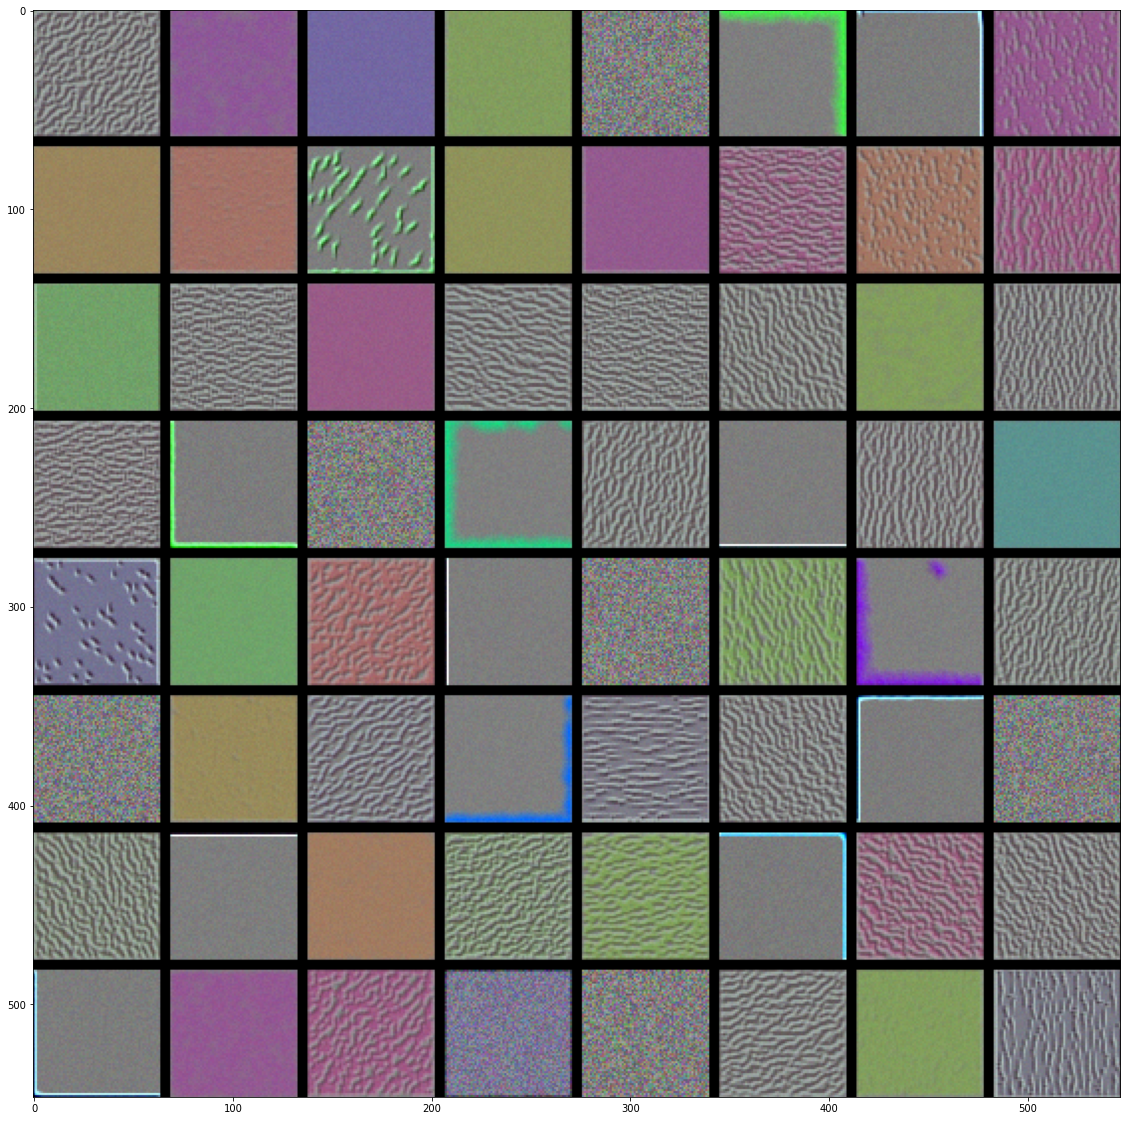

In [37]:
layer_name = 'block1_conv1'
size = 64
margin = 5

results = np.zeros((8 * size + 7 * margin, 8 * size + 7 * margin, 3), dtype=int)

for i in range(8):
    for j in range(8):
        filter_img = generate_pattern(layer_name, i + (j * 8), size)
        
        horizontal_start = i * size + i * margin
        horizontal_end = horizontal_start + size
        vertical_start = j * size + j * margin
        vertical_end = vertical_start + size
        results[horizontal_start:horizontal_end, vertical_start:vertical_end, :] = filter_img
        
plt.figure(figsize=(20, 20))
plt.imshow(results)

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16


model = VGG16(weights='imagenet', include_top=False)


In [39]:

from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np

img_path = './grad_cam_4_0.jpeg'

img = image.load_img(img_path, target_size=(224, 224))

x = image.img_to_arry(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

preds = model.predict(x)

decode_predictions(preds, top=3)[0]

ResourceExhaustedError: OOM when allocating tensor with shape[25088,4096] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node fc1_1/kernel/Initializer/random_uniform/RandomUniform (defined at <ipython-input-39-a7af6ead973a>:1) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


Original stack trace for 'fc1_1/kernel/Initializer/random_uniform/RandomUniform':
  File "/usr/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.6/dist-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/usr/local/lib/python3.6/dist-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.6/dist-packages/tornado/platform/asyncio.py", line 199, in start
    self.asyncio_loop.run_forever()
  File "/usr/lib/python3.6/asyncio/base_events.py", line 438, in run_forever
    self._run_once()
  File "/usr/lib/python3.6/asyncio/base_events.py", line 1451, in _run_once
    handle._run()
  File "/usr/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/usr/local/lib/python3.6/dist-packages/tornado/ioloop.py", line 688, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/usr/local/lib/python3.6/dist-packages/tornado/ioloop.py", line 741, in _run_callback
    ret = callback()
  File "/usr/local/lib/python3.6/dist-packages/tornado/gen.py", line 814, in inner
    self.ctx_run(self.run)
  File "/usr/local/lib/python3.6/dist-packages/tornado/gen.py", line 162, in _fake_ctx_run
    return f(*args, **kw)
  File "/usr/local/lib/python3.6/dist-packages/tornado/gen.py", line 775, in run
    yielded = self.gen.send(value)
  File "/usr/local/lib/python3.6/dist-packages/ipykernel/kernelbase.py", line 365, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/usr/local/lib/python3.6/dist-packages/tornado/gen.py", line 234, in wrapper
    yielded = ctx_run(next, result)
  File "/usr/local/lib/python3.6/dist-packages/tornado/gen.py", line 162, in _fake_ctx_run
    return f(*args, **kw)
  File "/usr/local/lib/python3.6/dist-packages/ipykernel/kernelbase.py", line 272, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/usr/local/lib/python3.6/dist-packages/tornado/gen.py", line 234, in wrapper
    yielded = ctx_run(next, result)
  File "/usr/local/lib/python3.6/dist-packages/tornado/gen.py", line 162, in _fake_ctx_run
    return f(*args, **kw)
  File "/usr/local/lib/python3.6/dist-packages/ipykernel/kernelbase.py", line 542, in execute_request
    user_expressions, allow_stdin,
  File "/usr/local/lib/python3.6/dist-packages/tornado/gen.py", line 234, in wrapper
    yielded = ctx_run(next, result)
  File "/usr/local/lib/python3.6/dist-packages/tornado/gen.py", line 162, in _fake_ctx_run
    return f(*args, **kw)
  File "/usr/local/lib/python3.6/dist-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python3.6/dist-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 2867, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 2895, in _run_cell
    return runner(coro)
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 3072, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 3263, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 3343, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-39-a7af6ead973a>", line 1, in <module>
    model = VGG16(weights='imagenet')
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/applications/vgg16.py", line 187, in VGG16
    x = layers.Dense(4096, activation='relu', name='fc1')(x)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py", line 766, in __call__
    self._maybe_build(inputs)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py", line 2106, in _maybe_build
    self.build(input_shapes)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/layers/core.py", line 1192, in build
    trainable=True)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py", line 457, in add_weight
    caching_device=caching_device)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/training/tracking/base.py", line 810, in _add_variable_with_custom_getter
    **kwargs_for_getter)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/base_layer_utils.py", line 142, in make_variable
    shape=variable_shape if variable_shape else None)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/variables.py", line 260, in __call__
    return cls._variable_v1_call(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/variables.py", line 221, in _variable_v1_call
    shape=shape)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/variables.py", line 199, in <lambda>
    previous_getter = lambda **kwargs: default_variable_creator(None, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/variable_scope.py", line 2618, in default_variable_creator
    shape=shape)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/variables.py", line 264, in __call__
    return super(VariableMetaclass, cls).__call__(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/resource_variable_ops.py", line 1585, in __init__
    distribute_strategy=distribute_strategy)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/resource_variable_ops.py", line 1712, in _init_from_args
    initial_value = initial_value()
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/initializers/initializers_v2.py", line 410, in __call__
    shape, dtype=_get_dtype(dtype), **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops_v2.py", line 600, in __call__
    return self._random_generator.random_uniform(shape, -limit, limit, dtype)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops_v2.py", line 1082, in random_uniform
    shape=shape, minval=minval, maxval=maxval, dtype=dtype, seed=self.seed)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/util/dispatch.py", line 201, in wrapper
    return target(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/random_ops.py", line 303, in random_uniform
    shape, dtype, seed=seed1, seed2=seed2)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gen_random_ops.py", line 739, in random_uniform
    name=name)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/op_def_library.py", line 750, in _apply_op_helper
    attrs=attr_protos, op_def=op_def)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/ops.py", line 3536, in _create_op_internal
    op_def=op_def)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/ops.py", line 1990, in __init__
    self._traceback = tf_stack.extract_stack()
